<a href="https://colab.research.google.com/github/MELAI-1/WORKSHOPS-AND-SCIENTIFIC-OUTREACH/blob/main/%20I-X%20AI%20in%20Science-Imperial/Final__RL_tutorial_student_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Design Materials with optimal propertities

<div align="center">
  <b>Part 1: Background</b>
  
</div>


<div style="display: flex; justify-content: center;">
    <iframe src="https://drive.google.com/file/d/152YDnfX35z1_jj8zwjhrKmfmoJgBRt3p/view?usp=sharing" width="50%" height="300px"></iframe>
</div>

[Lecture slides](https://drive.google.com/file/d/152YDnfX35z1_jj8zwjhrKmfmoJgBRt3p/view?usp=sharing)

<div align="center">
  <b>Part 2: Hands on</b>
</div>

### Hands on: Self-Driving Taxi with Reinforcement Tabular Q-Learning
This tutorial is updated and based on [here](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

In [ ]:
!pip install gym
!pip install pygame
!pip install cmake 'gym[atari]' scipy
!pip install numpy==1.23.5

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

1. Drop off the passenger to the right location.
2. Save passenger's time by taking minimum time possible to drop off
3. Take care of passenger's safety and traffic rules

### A random start of state

In [ ]:
import gym
import numpy as np

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

env.reset()
env.render()

**Tips: Understanding the env.**

In [ ]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


**1. Rewards**

<div style=\"background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;\">
    <strong>💡 What kind of rewards we need to design? </strong>
</div>

Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly.
<details>
<summary> <b>  Here a few points to consider 💡: </b> </summary>
i. The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired

ii. The agent should be penalized if it tries to drop off a passenger in wrong locations

iii. The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible
</details>

**2. State Space**

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B).

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

We also account for one (1) additional passenger state of being inside the taxi.
<details>
<summary> <b>  Calculate all the possible states of the taxi environment 💡: </b> </summary>
we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has  **5 * 5 * 5 * 4 = 500**
 total possible states.
</details>

Check if your calculation is correct. 😸


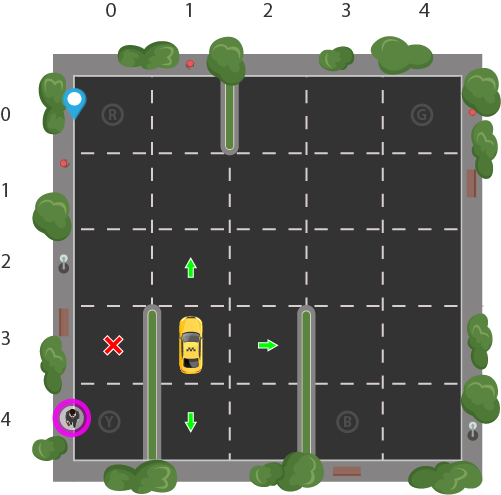

**3. Actions**

The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger. In other words, we have six possible actions:

 **0-south, 1-north, 2-east, 3-west, 4-pickup, 5-dropoff**

You'll notice in the illustration above, that the taxi cannot perform certain actions in **certain states due to walls**. In environment's code, we will simply provide a **-1** penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

Options: mannually set the state of the env

In [ ]:
state = env.encode(3, 2, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

State: 348


<strong> Reward table of an env </strong>

We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a **states * actions** matrix.

1. This dictionary has the structure **{action: [(probability, nextstate, reward, done)]}**.

2. Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

In [ ]:
env.P[328] #Transition dynamics

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

### Without RL just random search

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1

In [ ]:
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1009
Penalties incurred: 317


### With Reinforcement learning, we use Q-learning here

**Q-learning**

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

If the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for **pickup** is higher when compared to other actions, like dropoff or north.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

**Q(state, action) = (1-alpha)Q(state, action) + alpha * (reward + gamma * (max) Q(nextstate, all actions)**


Where:

-
 (alpha) is the learning rate (0 < alpha <= 1)
) - Just like in supervised learning settings,
 is the extent to which our Q-values are being updated in every iteration.

-
 (gamma) is the discount factor (0 <= gamma <= 1
) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.


**Q-Table**

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.

Breaking it down into steps, we get

1. Initialize the Q-table by all zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.

If goal state is reached, then end and repeat the process.

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Exploiting learned values

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called
 **"epsilon"** to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

### **Implementing Q-learning**

### Train

I define the function which will return the best action after training

In [ ]:
def get_best_action(q_table, state):
    """
    Determines the best action for a given state based on Q-table values

    Parameters:
    - q_table: The Q-table containing action values
    - state: The current state index

    Returns:
    - best_action: The action with the highest Q-value
    - max_value: The corresponding maximum Q-value
    """
    # Extract action values for the given state
    action_values = q_table[state]

    # Find the max value and its index using NumPy's argmax
    best_action = np.argmax(action_values) # Changed this line to use np.argmax
    max_value = action_values[best_action]

    # Mapping actions to their meanings
    action_meanings = {
        0: 'South',
        1: 'North',
        2: 'East',
        3: 'West',
        4: 'Pickup',
        5: 'Dropoff'
    }

    return {
        'best_action': best_action,
        'best_action_meaning': action_meanings[best_action],
        'max_value': max_value
    }


In [ ]:
import gym
import numpy as np
from IPython.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import os

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Render as RGB images

# Define hyperparameters
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 100
max_steps_per_episode = 100

# Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    #total_reward = 0
    for step in range(max_steps_per_episode):
        #frame = env.render()  # Render the environment as an RGB array
        #frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])
        ## the way to use epsilon
        # if np.random.rand() < epsilon:
        #     action = np.random.choice(action_space_size)  # Explore
        # else:
        #     action = np.argmax(q_table[state])  # Exploit

        # Perform the action
        next_state, reward, done, truncated, info = env.step(action)
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        state = next_state
        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay) #did you notice that the epsilon is not used here? how to modify?



print("Training complete.")

# # Save frames as a GIF wit:h infinite looping
# gif_path = "taxi_v3_simulation.gif"
# frames[0].save(
#     gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0
# )
# print(f"GIF saved at {gif_path}")

# # Display the GIF in the notebook with infinite looping
# from IPython.display import HTML
# display(HTML(f'<img src="{gif_path}" style="display:block;">'))


Training complete.


In [ ]:
result_100 = get_best_action(q_table, 328)
print(f"Best Action: {result_100['best_action_meaning']} (Index: {result_100['best_action']})")
print(f"Max Q-Value: {result_100['max_value']}")

Best Action: South (Index: 0)
Max Q-Value: -0.5847967256005999


Answers: Go for "**West**" if we train the q-table with 100 episodes.

In [ ]:
# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Render as RGB images

# Define hyperparameters
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000
max_steps_per_episode = 100

# Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    #total_reward = 0
    for step in range(max_steps_per_episode):
        #frame = env.render()  # Render the environment as an RGB array
        #frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])
        ## the way to use epsilon
        # if np.random.rand() < epsilon:
        #     action = np.random.choice(action_space_size)  # Explore
        # else:
        #     action = np.argmax(q_table[state])  # Exploit

        # Perform the action
        next_state, reward, done, truncated, info = env.step(action)
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        state = next_state
        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay) #did you notice that the epsilon is not used here? how to modify?



print("Training complete.")

# # Save frames as a GIF wit:h infinite looping
# gif_path = "taxi_v3_simulation.gif"
# frames[0].save(
#     gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0
# )
# print(f"GIF saved at {gif_path}")

# # Display the GIF in the notebook with infinite looping
# from IPython.display import HTML
# display(HTML(f'<img src="{gif_path}" style="display:block;">'))


Training complete.


In [ ]:
result_1000 = get_best_action(q_table, 328)
print(f"Best Action: {result_1000['best_action_meaning']} (Index: {result_1000['best_action']})")
print(f"Max Q-Value: {result_1000['max_value']}")

Best Action: North (Index: 1)
Max Q-Value: -3.8649205630816


Answers: Go for "**North**" if we train the q-table with 1000 episodes.

In [ ]:
# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Render as RGB images

# Define hyperparameters
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 5000
max_steps_per_episode = 100

# Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    #total_reward = 0
    for step in range(max_steps_per_episode):
        #frame = env.render()  # Render the environment as an RGB array
        #frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])
        ## the way to use epsilon
        # if np.random.rand() < epsilon:
        #     action = np.random.choice(action_space_size)  # Explore
        # else:
        #     action = np.argmax(q_table[state])  # Exploit

        # Perform the action
        next_state, reward, done, truncated, info = env.step(action)
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        state = next_state
        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay) #did you notice that the epsilon is not used here? how to modify?



print("Training complete.")

# # Save frames as a GIF wit:h infinite looping
# gif_path = "taxi_v3_simulation.gif"
# frames[0].save(
#     gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0
# )
# print(f"GIF saved at {gif_path}")

# # Display the GIF in the notebook with infinite looping
# from IPython.display import HTML
# display(HTML(f'<img src="{gif_path}" style="display:block;">'))


Training complete.


In [ ]:
result_5000 = get_best_action(q_table, 328)
print(f"Best Action: {result_5000['best_action_meaning']} (Index: {result_5000['best_action']})")
print(f"Max Q-Value: {result_5000['max_value']}")

Best Action: North (Index: 1)
Max Q-Value: 8.6980411914447


Answers: Go for "**North**" if we train the q-table with 5000 episodes.

### Test

In [ ]:
# Testing the trained agent and rendering as GIF
frames = []  # Store frames for GIF
test_episodes = 1
for episode in range(test_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0
    for step in range(max_steps_per_episode):
        frame = env.render()  # Render the environment as an RGB array
        frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])

        # Correctly unpack the result of env.step()
        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated  # Handle termination
        ## what is different between training and testing?
        total_reward += reward
        state = next_state
        if done:
            break

print(f"Total reward per episode: {total_reward / test_episodes}")

env.close()

# Save frames as a GIF
gif_path = "taxi_v3_simulation.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0)
print(f"GIF saved at {gif_path}")


# Display the GIF in the notebook
from IPython.display import Image as IPImage
display(IPImage(gif_path))

<div align="center">
  <b>Part 2.1: Homework</b>
</div>

### Reflection and improvement
Requirements on homework: finish the task and import the notebook as a **pdf** with your codes, plots, results and discussions.
#### Task 1: **Hyperparameters and optimizations**

as we see and we know to optimize our q-learning we can ⁉



*   Try exploration during our strategies and for that we can  use **Epsilon-Greedy Decay**
*   Hyperparameter Tuning
* and sometimes also improve the strategy



In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from PIL import Image
import os
import tqdm as tqdm

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Define hyperparameters
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 5000
max_steps_per_episode = 100

# Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))

# Track rewards for evaluation
rewards_per_episode = []

# Training loop
for episode in tqdm.tqdm(range(episodes)):
    state = env.reset()[0]
    done = False
    total_reward = 0
#epsilon-greedy algorithm
    for step in range(max_steps_per_episode):
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit

        # Perform the action
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        # Update Q-table using Q-learning formula
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )

        state = next_state

        if done or truncated:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track progress
    rewards_per_episode.append(total_reward)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Episode: {episode+1}, Average Reward (last 100): {avg_reward:.2f}, Epsilon: {epsilon:.4f}")

print("Training complete.")


In [ ]:
# Plot training progress
plt.figure(figsize=(10, 5))
window_size = 100
avg_rewards = [np.mean(rewards_per_episode[max(0, i-window_size):i+1])
               for i in range(len(rewards_per_episode))]
plt.plot(rewards_per_episode, alpha=0.5, label='Rewards')
plt.plot(avg_rewards, label=f'Average Reward (window={window_size})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Function to evaluate the trained agent
def evaluate_agent(env, q_table, num_episodes=10, render=False):
    total_rewards = []
    frames = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0

        while not done:
            if render and episode == 0:  # Only render the first episode
                frames.append(Image.fromarray(env.render()))

            # Always choose the best action
            action = np.argmax(q_table[state])
            next_state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            state = next_state

            if done or truncated:
                break

        total_rewards.append(episode_reward)

    # Save the first episode as a GIF if rendering was enabled
    if render and frames:
        gif_path = "taxi_v3_solution.gif"
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0
        )
        # print(f"GIF saved at {gif_path}")
        # display(HTML(f'<img src="{gif_path}" style="display:block;">'))

    return np.mean(total_rewards)

# Evaluate the trained agent
avg_reward = evaluate_agent(env, q_table, num_episodes=10, render=True)
print(f"Average reward over 10 evaluation episodes: {avg_reward}")

# Close the environment
env.close()

Average reward over 10 evaluation episodes: 8.6


In [ ]:
#evaluate the agent
# Testing the trained agent and rendering as GIF
frames = []  # Store frames for GIF
test_episodes = 1
for episode in range(test_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0
    for step in range(max_steps_per_episode):
        frame = env.render()  # Render the environment as an RGB array
        frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])

        # Correctly unpack the result of env.step()
        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated  # Handle termination
        ## what is different between training and testing?
        total_reward += reward
        state = next_state
        if done:
            break

print(f"Total reward per episode: {total_reward / test_episodes}")

env.close()

# Save frames as a GIF
gif_path = "taxi_v3_simulation.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0)
print(f"GIF saved at {gif_path}")


# Display the GIF in the notebook
from IPython.display import Image as IPImage
display(IPImage(gif_path))


# **Comments:**

In this part I tried:


*   different space of parameters
*   define the number of step after no change we can break



#### Task 2: **Which field you think also used this Q learning**

Q-Learning has revolutionized :

*  **Robotic navigation and autonomous systems** that enable machines to learn optimal decision-making strategies through trial and error. In robotics, algorithms can help robots learn complex movement patterns, obstacle avoidance, and efficient path planning by continuously updating their understanding of environmental interactions.

* **has transformed algorithmic trading** by enabling systems to develop sophisticated investment strategies. These learning agents can analyze market conditions, predict potential outcomes, and make dynamic trading decisions by learning from historical data and adapting to changing market environments, potentially outperforming traditional rule-based trading methods.

* **Autonomous vehicles** represent another critical domain where Q-Learning demonstrates immense potential. By learning from countless simulated and real-world driving scenarios, these intelligent systems can develop nuanced decision-making capabilities, improving navigation, predicting potential hazards, and making split-second choices that prioritize passenger safety and efficient route optimization.

* **Healthcare applications of Q-Learning**are emerging as powerful tools for personalized medicine and treatment optimization. Machine learning models can analyze patient data, learn from treatment outcomes, and suggest personalized intervention strategies, potentially identifying optimal treatment paths that might not be immediately apparent to human practitioners.

Importantly, when faced with a problem that can be modeled as a sequential decision-making process with discrete states and actions, Q-Learning emerges as the most intuitive and foundational algorithmic approach. Its core strength lies in its simplicity and ability to learn optimal strategies through iterative exploration and exploitation, making it the default baseline algorithm for reinforcement learning problems where an agent must learn to make a sequence of decisions in an uncertain environment.

<div align="center">
  <b>Part 3: Applying reinforcement learning in materials research</b>
</div>

#### Task elaboration:
Now change the agent to a thermoelectric material Bi2Te3 (taxi here), you can download the structure from [here](https://next-gen.materialsproject.org/materials/mp-541837?formula=Bi2Se3); you have the options to change Te into Se and/or S.

1. reward is the predicted zT value
2. we use the 0.1 incrementally, therefore we have the choice that Te ∈ [0, 1], Se ∈ [0, 1], and S ∈ [0, 1], and the constraint that Te + Se + S = 1
3. Therefore we have 10 * 10 * 10 (3D grid) options with some options that are not valid.
4. the anion sites can choose to increase or decrease by a 0.1 step. Te-increase, Te-decrease, Se-increase, Se-decrese, S-increase, S-decrease
5. the destination is when the composition with maximal zT is reached.

In [ ]:
# Installation of libraries
!pip install optimade --quiet
!pip install matminer --quiet
!pip install elementembeddings --quiet
!pip install pymatviz --quiet
!pip install plotly --quiet
!pip install numpy==1.23.5

Database queries: Chemical space of thermoelectric materials
We can use [matminer](https://matminer.readthedocs.io/en/latest/) to access a dataset. Today we will turn to thermoelectric materials.

Thermoelectric devices convert temperature differences directly into electrical voltage, enabling applications in power generation and refrigeration. Their efficiency is characterised by the dimensionless figure of merit (zT), which depends on electrical conductivity, Seebeck coefficient, and thermal conductivity (read more here). Let's explore the diverse compositions that give rise to these properties.

In [ ]:
## code hint
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materals datasets

print(matminer.datasets.dataset_retrieval.get_all_dataset_info('ucsb_thermoelectrics'))

In [ ]:
#process the dataset into dataframe
# Use matminer to download the dataset
df = load_dataset('ucsb_thermoelectrics')

print(f'The full dataset contains {df.shape[0]} entries. \n')
print('The DataFrame is shown below:')
df.head(10)

In [ ]:
# Display the columns of the dataset
print("Columns in the dataset:")
print(df.columns)

# Check for any missing values in the dataset
print("\nChecking for missing values:")
print(df.isnull().sum())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of zT values
plt.figure(figsize=(5, 4))
sns.histplot(df['zT'], bins=20, kde=True)
plt.title('Thermoelectric figure of merit (zT)')
plt.xlabel('zT (unitless)')
plt.ylabel('Frequency')
plt.show()

For featurisation, we recommend using the [elementembeddings](https://wmd-group.github.io/ElementEmbeddings/stable/) library.

In [ ]:
# Use matminer to featurise the dataset
from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core import Composition
df2 = df.copy()
df2['composition'] = df2.composition.apply(lambda x: Composition(x))

# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however, this can slow performance, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Featurise using the ElementProperty featuriser
df2 = el_prop_featuriser.featurize_dataframe(df2, col_id='composition')

# Print the shape of the DataFrame
print(df2.shape)
df2.head()


In [ ]:
# Extract the feature columns (excluding the first three)
feature_columns = df2.columns[12:]

# Create a unique colour for each feature
colors = [plt.cm.jet(i / float(len(feature_columns))) for i in range(len(feature_columns))]

# Plot the distribution of feature values with different colours
plt.figure(figsize=(5, 4))
for i, column in enumerate(feature_columns):
    df2[column].plot(kind='hist', bins=10, alpha=0.5, color=colors[i], label=column)

plt.title('Feature Distributions')
plt.show()

MinMaxScaler is a data scaling technique to transform numerical features within the range [0, 1]. It linearly scales data, preserving relationships between values, making it suitable for algorithms sensitive to feature magnitudes.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = df2.copy()

# Step 1: Standardise the feature columns
scaler = MinMaxScaler()
scaled_df[feature_columns] = scaler.fit_transform(scaled_df[feature_columns])

# Step 2: Plot the standardised feature distributions
plt.figure(figsize=(5, 4))
for column in feature_columns:
    scaled_df[column].plot(kind='hist', bins=20, alpha=0.5, label=column)

plt.title('Standardised Feature Distributions')
plt.show()

Finally, let's prepare the data for model training. We need to split the dataset into the target variable zT and the input features. For the input features, we must remove any non-numerical data to avoid getting errors later in our workflow.


In [ ]:
df2 = df2.dropna()
# Define the features we want
features_to_drop = ['composition', 'crystallinity', 'synthesis', 'spacegroup',
       'rho (ohm.cm)', 'S [muV/K]', 'PF [W/mK^2]', 'zT', 'kappa [W/mK]',
       'sigma [S/cm]', 'T [K]', 'src']
feature_cols = [col for col in list(df2.columns) if col not in features_to_drop]

# Get an array of the features
X = df2[feature_cols].values
scaled_X = scaled_df[feature_cols].values

# Get an array of the target variable
y = df2['zT'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (690, 132)
Shape of y: (690,)


##Model choice

We are dealing with a supervised regression problem, so should choose a suitable machine learning model. We can start by rebuilding a random forest. Are you curious if the feature scaling has an effect? I am.


In [ ]:
# Random forest - original features
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Define the model
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf.fit(X,y)

# Wrap the lines of code for later sections
def make_prediction_plot(X, y, model, label):
    y_pred = rf.predict(X)  # Calculate predictions here
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} True')
    ax.set_ylabel(f'{label} Predicted')
    plt.show()
    return y_pred  # Return y_pred

# Performance
y_pred = make_prediction_plot(X, y, rf, 'zT')

print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} ')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y,y_pred)):.3f}')
print(f'The training r^2 = {rf.score(X,y):.3f}')

Now build your material env using gym
* action space: we only care about the compositional ratio of Te:Se from 0 to 1 with a step of 0.01
* reward function: you need to train a surrogate model based on the known database you have downloaded.
* train the RL model

In [ ]:
## featurize the composition of our target
import numpy as np
import pandas as pd
from pymatgen.core import Composition

def generate_random_Bi2Te3_substitution():
    # Discretize the range 0 to 3 in steps of 0.1
    increments = np.arange(0, 3.01, 0.3)

    # Generate all valid (Te, Se) pairs, compute S = 3 - Te - Se
    valid_combinations = []
    for te in increments:
        for se in increments:
            s = 3.0 - te - se
            if 0 <= s <= 3 and np.isclose(s % 0.3, 0, atol=1e-8):
                valid_combinations.append((round(te, 1), round(se, 1), round(s, 1)))

    # Choose one random combination
    te_amt, se_amt, s_amt = valid_combinations[np.random.randint(len(valid_combinations))]

    # Construct full composition including 0s
    comp_dict = {
        "Bi": 2,
        "Te": te_amt,
        "Se": se_amt,
        "S": s_amt
    }

    # Create and return the Composition object
    comp = Composition(comp_dict)
    return comp

# Generate 3 compositions
compositions = [generate_random_Bi2Te3_substitution() for _ in range(3)]

# Store in a DataFrame
df_alloy = pd.DataFrame({
    "composition": [comp for comp in compositions]
})

print(df_alloy)
df_alloy = el_prop_featuriser.featurize_dataframe(df_alloy, col_id='composition')

In [ ]:
features_to_drop = ['composition', 'crystallinity', 'synthesis', 'spacegroup',
       'rho (ohm.cm)', 'S [muV/K]', 'PF [W/mK^2]', 'zT', 'kappa [W/mK]',
       'sigma [S/cm]', 'T [K]', 'src']
feature_cols = [col for col in list(df_alloy.columns) if col not in features_to_drop]

# Get an array of the features
X = df_alloy[feature_cols].values

reward_example = rf.predict(X)
print(reward_example)

[0.58638093 0.4799631  0.52602026]


##start the RL part

Actually for this 3D env, we are going to use it for the alloy chemical space, for the alloy, instead of having a 0.1 step, we now have 0.3, and so we have 11 * 11 *11 states or grid size. The reward is the predicted zT values of a composition. For the actions space, for each state, like the taxi, the alloy composition can choose to drop 0.3 Te or increase 0.3 Te, similarly for Se or S. Therefore have 6 actions. We don't have to do pickup, and dropoff, instead we need to find the composition with the highest zT values. the zT values can be calculated with a given function like function(composition). I hope for every given random starting point, the agent can quickly go to the optimal point of composition within a short trajectory.

State = (Te_idx, Se_idx, S_idx); each index ∈ [0, 10]

Action space = 6 actions:

0: Te +0.3 (if Te < 3.0)

1: Te -0.3 (if Te > 0)

2: Se +0.3

3: Se -0.3

4: S +0.3

5: S -0.3

In [ ]:
from pymatgen.core import Composition
import gym
from gym import spaces
import numpy as np

class AlloyCompositionEnv(gym.Env):
    def __init__(self, zt_func, max_steps=20):
        super().__init__()
        self.grid_size = 1331 ## change to the correct value
        self.step_size = 0.3 ## change to the correct value
        self.max_index = self.grid_size - 1
        self.zt_func = zt_func
        self.max_steps = max_steps
        self.current_step = 0

        self.observation_space = spaces.MultiDiscrete([self.grid_size] * 3)
        self.action_space = spaces.Discrete(6)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        while True:
            self.state = np.random.randint(0, self.grid_size, size=3)
            if abs(sum(self.state) * self.step_size - 3.0) < 0.01:
                break
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return tuple(self.state)

    def _state_to_composition(self, state):
        te, se, s = state * self.step_size
        composition_dict = {"Bi": 2}
        if te > 0: composition_dict["Te"] = round(te, 2)
        if se > 0: composition_dict["Se"] = round(se, 2)
        if s > 0:  composition_dict["S"] = round(s, 2)
        return Composition(composition_dict)

    def step(self, action):
        delta = [0, 0, 0]
        idx = action // 2
        sign = 1 if action % 2 == 0 else -1
        delta[idx] = sign

        next_state = np.clip(self.state + delta, 0, self.max_index)
        if abs(np.sum(next_state) * self.step_size - 3.0) > 0.01:
            reward = -1.0  # Invalid move
        else:
            self.state = next_state
            comp = self._state_to_composition(self.state)
            reward = self.zt_func(comp)

        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self._get_obs(), reward, done, False, {}

    def render(self):
        comp = self._state_to_composition(self.state)
        print(f"Composition: {comp}")

In [ ]:
def zt_func(self):
    # Store in a DataFrame
    #define it based on what we do before
    return reward

In [ ]:
def zt_func(self):
    # Convert indices to actual property values
    # Assuming each index maps to a value in the physical property space
    Te = self.Te_idx * 0.3  # Temperature or tellurium content
    Se = self.Se_idx * 0.3  # Seebeck coefficient or selenium content
    S = self.S_idx * 0.3    # Electrical conductivity or sulfur content

    # Calculate zT based on thermoelectric theory
    # A common formula for zT is: zT = (S² * σ * T) / κ
    # where S is Seebeck coefficient, σ is electrical conductivity,
    # T is temperature, and κ is thermal conductivity

    # For this implementation, let's use a simplified model:
    # Higher S contributes positively
    # Optimal ratio between Te and Se
    # Penalize extreme values

    # Basic components
    seebeck_term = Se**2
    conductivity_term = S

    # Optimal ratio term (example: best performance when Te:Se is close to 2:1)
    ratio_term = 1 - 0.5 * abs((2*Se) - Te) / max(Te, 0.1)

    # Thermal properties (simplified)
    thermal_term = 1 / (1 + 0.2 * Te)  # Higher Te leads to higher thermal conductivity

    # Calculate zT
    zt = seebeck_term * conductivity_term * ratio_term * thermal_term

    # Add some domain knowledge through constraints
    # If values are outside physical ranges, penalize heavily
    if Te < 0.3 or Te > 3.0 or Se < 0 or Se > 3.0 or S < 0 or S > 3.0:
        zt *= 0.5

    # Add some domain-specific features (e.g., known good combinations)
    # For example, if Te ≈ 1.5 and Se ≈ 0.9, it's a good composition
    if (1.4 < Te < 1.6) and (0.8 < Se < 1.0) and (1.2 < S < 1.8):
        zt *= 1.2  # Bonus for known good composition

    # Store the result for analysis
    self.current_zt = zt

    # For reinforcement learning, we want to maximize zT
    reward = zt

    return reward

In [ ]:
# import numpy as np

# # Hyperparameters
# alpha = 0.1           # learning rate
# gamma = 0.99          # discount factor
# epsilon = 1.0         # exploration rate
# epsilon_decay = 0.995
# epsilon_min = 0.01
# episodes = 100 #change to your values
# max_steps = 100 #change to your values

# # Environment and Q-table setup
# env = AlloyCompositionEnv(zt_func=zt_func, max_steps=max_steps)
# env.reset()
# #constructure the initial q_table
# state_space = (0, 0, 0)    # change to your values, te_idx, se_idx, s_idx,
# action_space = 6              # 6 actions: ±0.3 for Te, Se, S
# q_table = np.zeros(state_space + (action_space,))

# # ε-greedy action selector
# def select_action(state, q_table, epsilon, action_space):
#     if np.random.rand() < epsilon:
#         return env.action_space.sample()
#     else:
#         return np.argmax(q_table[tuple(state)])

# # Reward tracking
# reward_history = []

# for episode in range(episodes):
#     state, _ = env.reset()
#     total_reward = 0
#     best_reward = -np.inf

#     for step in range(max_steps):
#         action = select_action(state, q_table, epsilon, env.action_space)
#         next_state, reward, done, _, _ = env.step(action)

#         state_idx = tuple(state)
#         next_state_idx = tuple(next_state)

#         # Q-learning update
#         q_table[state_idx][action] = q_table[state_idx][action] + alpha * (
#             reward + gamma * np.max(q_table[next_state_idx]) - q_table[state_idx][action]
#         )

#         total_reward += reward
#         best_reward = max(best_reward, reward)
#         state = next_state

#         if done:
#             break

#     # Decay epsilon
#     epsilon = max(epsilon_min, epsilon * epsilon_decay)
#     reward_history.append(best_reward)

#     if episode % 10 == 0:
#         print("Episode %d: Best zT = %.4f, ε = %.3f" % (episode, best_reward, epsilon))

# print("Training complete.")


In [ ]:
##Track the history
def track_history(self, state, action, next_state, reward, done=False):
    """
    Track the history of states, actions, and performance metrics.
    Call this function after each step in your RL environment.

    Parameters:
    - state: Tuple or dict representing the state before action (Te_idx, Se_idx, S_idx)
    - action: Integer (0-5) representing the action taken
    - next_state: Tuple or dict representing the state after action
    - reward: Float value (zT) received from the environment
    - done: Boolean indicating if the episode has ended
    """
    # Initialize history storage if it doesn't exist
    if not hasattr(self, 'history'):
        self.history = {
            'states': [],
            'actions': [],
            'rewards': [],
            'compositions': [],
            'metrics': [],
            'best_state': None,
            'best_reward': float('-inf'),
            'episodes': [],
            'current_episode': [],
            'episode_count': 0
        }

    # Unpack states
    if isinstance(state, tuple) or isinstance(state, list):
        Te_idx, Se_idx, S_idx = state
    else:  # Assume dictionary
        Te_idx = state.get('Te_idx', state.get(0, 0))
        Se_idx = state.get('Se_idx', state.get(1, 0))
        S_idx = state.get('S_idx', state.get(2, 0))

    if isinstance(next_state, tuple) or isinstance(next_state, list):
        next_Te_idx, next_Se_idx, next_S_idx = next_state
    else:  # Assume dictionary
        next_Te_idx = next_state.get('Te_idx', next_state.get(0, 0))
        next_Se_idx = next_state.get('Se_idx', next_state.get(1, 0))
        next_S_idx = next_state.get('S_idx', next_state.get(2, 0))

    # Convert indices to composition values
    Te = Te_idx * 0.3
    Se = Se_idx * 0.3
    S = S_idx * 0.3

    next_Te = next_Te_idx * 0.3
    next_Se = next_Se_idx * 0.3
    next_S = next_S_idx * 0.3

    # Map action to description
    action_descriptions = {
        0: "Te +0.3",
        1: "Te -0.3",
        2: "Se +0.3",
        3: "Se -0.3",
        4: "S +0.3",
        5: "S -0.3"
    }

    # Calculate step metrics
    step_size = ((next_Te_idx - Te_idx)**2 +
                 (next_Se_idx - Se_idx)**2 +
                 (next_S_idx - S_idx)**2)**0.5

    # Get current timestamp
    import time
    timestamp = time.time()

    # Build step record
    step_record = {
        'step': len(self.history['states']),
        'state': (Te_idx, Se_idx, S_idx),
        'next_state': (next_Te_idx, next_Se_idx, next_S_idx),
        'composition': {'Te': Te, 'Se': Se, 'S': S},
        'next_composition': {'Te': next_Te, 'Se': next_Se, 'S': next_S},
        'action': action,
        'action_desc': action_descriptions.get(action, f"Unknown action {action}"),
        'reward': reward,
        'step_size': step_size,
        'timestamp': timestamp,
        'done': done,
        'episode': self.history['episode_count']
    }

    # Add to current episode
    self.history['current_episode'].append(step_record)

    # Store in history
    self.history['states'].append((Te_idx, Se_idx, S_idx))
    self.history['actions'].append(action)
    self.history['rewards'].append(reward)
    self.history['compositions'].append({'Te': Te, 'Se': Se, 'S': S})
    self.history['metrics'].append({
        'step_size': step_size,
        'timestamp': timestamp
    })

    # Check if this is the best state found so far
    if reward > self.history['best_reward']:
        self.history['best_reward'] = reward
        self.history['best_state'] = {
            'state': (Te_idx, Se_idx, S_idx),
            'composition': {'Te': Te, 'Se': Se, 'S': S},
            'reward': reward,
            'step': len(self.history['states']) - 1,
            'episode': self.history['episode_count'],
            'timestamp': timestamp
        }

    # If episode is done, finish episode tracking
    if done:
        episode_data = {
            'episode_num': self.history['episode_count'],
            'steps': len(self.history['current_episode']),
            'start_state': self.history['current_episode'][0]['state'],
            'end_state': self.history['current_episode'][-1]['next_state'],
            'start_reward': self.history['current_episode'][0]['reward'],
            'final_reward': reward,
            'improvement': reward - self.history['current_episode'][0]['reward'],
            'total_distance': sum(step['step_size'] for step in self.history['current_episode']),
            'efficiency': (reward - self.history['current_episode'][0]['reward']) /
                         (sum(step['step_size'] for step in self.history['current_episode']) or 1),
            'timestamps': {
                'start': self.history['current_episode'][0]['timestamp'],
                'end': timestamp,
                'duration': timestamp - self.history['current_episode'][0]['timestamp']
            }
        }

        self.history['episodes'].append(episode_data)
        self.history['current_episode'] = []
        self.history['episode_count'] += 1

    return step_record

def get_trajectory_analysis(self):
    """
    Analyze the optimization trajectory and return comprehensive statistics.
    Call this at the end of training or whenever analysis is needed.
    """
    if not hasattr(self, 'history') or len(self.history['states']) == 0:
        return "No history available for analysis"

    import numpy as np
    from collections import Counter

    # Basic statistics
    total_steps = len(self.history['states'])
    total_episodes = self.history['episode_count']
    rewards = np.array(self.history['rewards'])

    # Trajectory analysis
    action_counts = Counter(self.history['actions'])

    # Calculate state diversity metrics
    unique_states = set(self.history['states'])
    state_diversity = len(unique_states) / total_steps if total_steps else 0

    # Calculate exploration vs exploitation metrics
    exploitation_ratio = sum(1 for i in range(1, total_steps)
                           if self.history['rewards'][i] >= self.history['rewards'][i-1]) / (total_steps - 1) if total_steps > 1 else 0

    # Performance metrics
    if total_episodes > 0:
        episode_lengths = [ep['steps'] for ep in self.history['episodes']]
        episode_improvements = [ep['improvement'] for ep in self.history['episodes']]
        episode_efficiencies = [ep['efficiency'] for ep in self.history['episodes']]
    else:
        episode_lengths = []
        episode_improvements = []
        episode_efficiencies = []

    # Calculate learning curve
    if total_episodes > 0:
        episode_final_rewards = [ep['final_reward'] for ep in self.history['episodes']]
        learning_curve = {
            'episode': list(range(1, total_episodes + 1)),
            'final_reward': episode_final_rewards,
            'moving_avg_5': [sum(episode_final_rewards[max(0, i-4):i+1]) / min(5, i+1)
                             for i in range(total_episodes)]
        }
    else:
        learning_curve = {'episode': [], 'final_reward': [], 'moving_avg_5': []}

    # Compile analysis
    analysis = {
        'total_steps': total_steps,
        'total_episodes': total_episodes,
        'reward_stats': {
            'min': float(rewards.min()) if total_steps else 0,
            'max': float(rewards.max()) if total_steps else 0,
            'mean': float(rewards.mean()) if total_steps else 0,
            'median': float(np.median(rewards)) if total_steps else 0,
            'std': float(rewards.std()) if total_steps else 0,
            'improvement': float(rewards[-1] - rewards[0]) if total_steps > 1 else 0
        },
        'best_composition': self.history['best_state'],
        'exploration_metrics': {
            'unique_states': len(unique_states),
            'state_diversity': state_diversity,
            'exploitation_ratio': exploitation_ratio,
            'action_distribution': {str(k): v for k, v in action_counts.items()}
        },
        'episode_stats': {
            'lengths': {
                'min': min(episode_lengths) if episode_lengths else 0,
                'max': max(episode_lengths) if episode_lengths else 0,
                'mean': sum(episode_lengths) / len(episode_lengths) if episode_lengths else 0
            },
            'improvements': {
                'min': min(episode_improvements) if episode_improvements else 0,
                'max': max(episode_improvements) if episode_improvements else 0,
                'mean': sum(episode_improvements) / len(episode_improvements) if episode_improvements else 0
            },
            'efficiencies': {
                'min': min(episode_efficiencies) if episode_efficiencies else 0,
                'max': max(episode_efficiencies) if episode_efficiencies else 0,
                'mean': sum(episode_efficiencies) / len(episode_efficiencies) if episode_efficiencies else 0
            }
        },
        'learning_curve': learning_curve
    }

    return analysis

def visualize_trajectory(self):
    """
    Return data formatted for visualization of the optimization trajectory.

    Notes:
    - Use this data with plotting libraries like matplotlib or plotly
    - For 3D trajectory visualization, use the states data
    - For learning curves, use the episode rewards data
    """
    if not hasattr(self, 'history') or len(self.history['states']) == 0:
        return "No history available for visualization"

    # Extract data for various plots
    steps = list(range(len(self.history['states'])))
    Te_idx_values = [state[0] for state in self.history['states']]
    Se_idx_values = [state[1] for state in self.history['states']]
    S_idx_values = [state[2] for state in self.history['states']]
    rewards = self.history['rewards']

    # Trajectory data (for 3D plotting)
    trajectory_data = {
        'steps': steps,
        'Te_idx': Te_idx_values,
        'Se_idx': Se_idx_values,
        'S_idx': S_idx_values,
        'rewards': rewards,
        'actions': self.history['actions']
    }

    # Episode performance data
    if len(self.history['episodes']) > 0:
        episode_data = {
            'episode': list(range(1, len(self.history['episodes']) + 1)),
            'final_reward': [ep['final_reward'] for ep in self.history['episodes']],
            'improvement': [ep['improvement'] for ep in self.history['episodes']],
            'steps': [ep['steps'] for ep in self.history['episodes']],
            'efficiency': [ep['efficiency'] for ep in self.history['episodes']]
        }
    else:
        episode_data = {'episode': [], 'final_reward': [], 'improvement': [], 'steps': [], 'efficiency': []}

    # Reward over time
    reward_data = {
        'steps': steps,
        'rewards': rewards,
        'cumulative_max': [max(rewards[:i+1]) for i in range(len(rewards))]
    }

    return {
        'trajectory': trajectory_data,
        'episodes': episode_data,
        'rewards': reward_data,
        'best_state': self.history['best_state']
    }